## MeanShift Algorithm Implementation with PyTorch
This notebook demonstrates the implementation of the MeanShift clustering algorithm using PyTorch. The notebook is structured following the concepts and methods discussed in [Lesson 12](https://course.fast.ai/Lessons/lesson12.html) of fast ai course on deep learning. It aims to provide a hands-on practice on key aspects such as tensor broadcasting, and utilizes tools like partial functions and animation techniques with Matplotlib. 



In [1]:
import torch
import matplotlib.pyplot as plt

# Ignore UserWarnings from PyTorch about CUDA capabilities
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
def plot_data(centroids, data, n_samples, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    for i in range(centroids.shape[0]):
        centroid = centroids[i]
        samples = data[i*n_samples: i*n_samples+n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s=1)
        ax.plot(*centroid, marker='x', color='m', markersize=5, mew=2)

### Create Data

In [3]:
n_clusters = 6
n_samples = 250
r_min, r_max = (0, 100)
torch.random.manual_seed(101); 
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

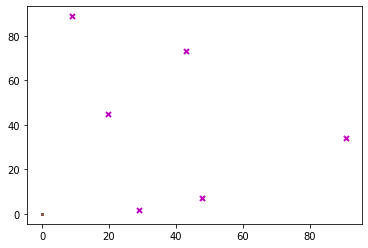

In [4]:
centroids = torch.rand((n_clusters, 2))*(r_max - r_min) + r_min
data = torch.zeros((n_clusters*n_samples, 2))
plot_data(centroids, data, n_samples)

Let's create n_samples around each of our cluster centroids using multivariate normal distribution with mean as the centroid and covariance matrix [[10.0, 0], [0, 5.0]]. Notice how the clusters are:
1. Axis aligned: This is because we are using a diagonal covariance matrix.
2. Stretch in x direction: This is because variance in x direction is 10 vs 5 in y direction.

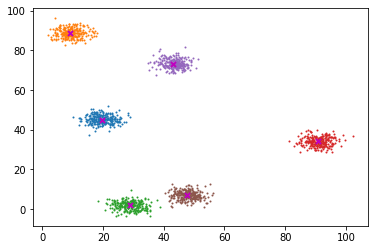

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
data = []
for i in range(n_clusters):
    data.append(
        MultivariateNormal(centroids[i], torch.diag(torch.tensor([10.0, 5.0]))).sample((n_samples,))
    )
data = torch.cat(data)
plot_data(centroids, data, n_samples)

### Gaussian Kernel
Lets create a gaussian kernel that penalizes large distances. The kernel takes as input distances and variance or bandwidth. 

In [6]:
def gaussian(d, bw):
    return torch.exp(-0.5 * (d/bw)**2) / (bw * torch.sqrt(2 * torch.tensor(3.14159265359)))

In [7]:
def plot_kernel(f):
    x = torch.linspace(0, 50, 1000)
    _, ax = plt.subplots()
    ax.plot(x, f(x))

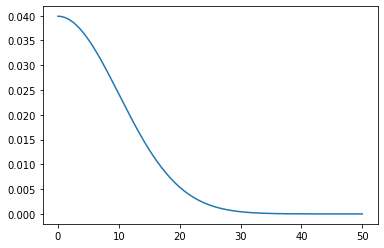

In [8]:
from functools import partial
plot_kernel(partial(gaussian, bw=10))

### One update
Create function one_update that updates the points once, according to the mean shift algorithm. The one update function takes as input data (X), batch_size and the kernel function f. f is such that f(d) applies the kernel on the distance(s) d, the shape of d is preserved. 

In [9]:
def one_update(data, kernel, bs=100):
    X = data.clone() # 1500, 2
    for i in range(0, X.shape[0], bs):
        slc = slice(i, min(i+bs, X.shape[0]))
        x = X[slc] # 5, 2
        dist = ((x[:,None,:] - X[None, :, :])**2).sum(2).sqrt()
        w = kernel(dist) # 5 x 1500
        w_norm = w / w.sum(1)[...,None] # 5 x 1500, 1500 x 2 
        data[slc] = (w_norm @ X)
    return data

### Meanshift Loop

In [10]:
def meanshift(data, num_iter=5, bandwidth=5, batch_size=50):
    X = data.clone()
    for i in range(num_iter):
        X = one_update(X, partial(gaussian, bw=bandwidth), bs=batch_size)
    return X

In [11]:

X = meanshift(data, num_iter=5, bandwidth=5, batch_size=500)

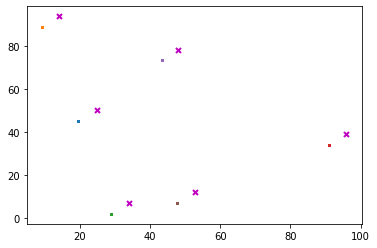

In [12]:
plot_data(centroids+5, X.cpu(), n_samples)

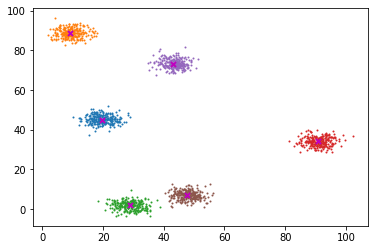

In [13]:
plot_data(centroids, data.cpu(), n_samples)

### Animation

In [14]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [15]:
def do_one(itr, X, ax):
    if itr > 0:
        X = one_update(X, partial(gaussian, bw=5), bs=500)
    ax.clear()
    plot_data(centroids, X.cpu(), n_samples, ax=ax)


In [16]:
X = data.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=1000, repeat=False, fargs=(X,ax))
plt.close()
HTML(ani.to_jshtml())

### Timing GPU vs CPU

In [17]:
data_gpu = data.cuda()
data_cpu = data.cpu()
print(data_gpu.device, data_cpu.device)

cuda:0 cpu


In [18]:
%time _ = meanshift(data_cpu, num_iter=5, bandwidth=10, batch_size=500)

CPU times: user 1.29 s, sys: 1.94 ms, total: 1.29 s
Wall time: 109 ms


In [19]:
# warmup
_ = meanshift(data_gpu, num_iter=5, bandwidth=10, batch_size=500)
%time _ = meanshift(data_gpu, num_iter=5, bandwidth=10, batch_size=500)

CPU times: user 8.33 ms, sys: 82 µs, total: 8.41 ms
Wall time: 8.43 ms


### Timing wrt batch size on GPU

In [20]:
for bs in [8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
    print(f'Batch size: {bs}')
    %time _ = meanshift(data_gpu, num_iter=5, bandwidth=10, batch_size=bs)

Batch size: 8
CPU times: user 495 ms, sys: 104 µs, total: 495 ms
Wall time: 494 ms
Batch size: 16
CPU times: user 247 ms, sys: 0 ns, total: 247 ms
Wall time: 247 ms
Batch size: 32
CPU times: user 126 ms, sys: 458 µs, total: 126 ms
Wall time: 126 ms
Batch size: 64
CPU times: user 64.9 ms, sys: 0 ns, total: 64.9 ms
Wall time: 65 ms
Batch size: 128
CPU times: user 33.6 ms, sys: 0 ns, total: 33.6 ms
Wall time: 33.4 ms
Batch size: 256
CPU times: user 16.5 ms, sys: 65 µs, total: 16.6 ms
Wall time: 16.6 ms
Batch size: 512
CPU times: user 8.36 ms, sys: 0 ns, total: 8.36 ms
Wall time: 8.37 ms
Batch size: 1024
CPU times: user 5.94 ms, sys: 0 ns, total: 5.94 ms
Wall time: 5.95 ms
Batch size: 2048
CPU times: user 3.12 ms, sys: 0 ns, total: 3.12 ms
Wall time: 3.12 ms
